In [1]:
%load_ext autoreload
%autoreload 2

# Functions

In [10]:
# Functions
def get_image_label_prediction(model, dataset, img_idx):
    """
    Obtains the original image, equalized image, label, filename, and prediction for a given image index.

    Parameters
    ----------
        * model (torch.nn.Module): The model used for prediction.
        * dataset (torch.utils.data.Dataset): The dataset containing the images.
        * img_idx (int): The index of the image to retrieve.

    Returns
    -------
        * img_or (numpy.ndarray): The original image.
        * img_equalized (numpy.ndarray): The equalized image.
        * label (int): The label of the image.
        * filename (str): The filename of the image.
        * pre/d (torch.Tensor): The prediction of the model for the image.
    """
    # Get original image from dataset
    img_or, _ = dataset.get_item(img_idx)
    img_or = np.array(img_or)
    # Get equalized image and its label
    img_equalized, label = dataset[img_idx]
    # Get filename
    filename = dataset.img_file_paths[img_idx].stem

    # Prediction
    with torch.no_grad():
        pred = model(img_equalized[None].to('cuda')).cpu()

    return img_or, img_equalized, label, filename, pred

def get_inference_iou(model, dataset):
    """
    Calculates the Intersection over Union (IoU) for each image in the dataset.

    Parameters
    ----------
        * model (object): The trained model used for prediction.
        * dataset (object): The dataset containing the images and labels.

    Returns
    -------
        * prediction_summary (DataFrame): A DataFrame containing the image index and the corresponding IoU.
    """
    # Define columns names
    columns_ = ['img_idx', 'prediction_iou']
    # Create dataframe
    prediction_summary = pd.DataFrame(columns = columns_)
    # Get dataset len
    dataset_len = len(dataset)

    for img_idx in range(dataset_len):

        img_or, img_equalized, label, filename, pred = get_image_label_prediction(model, dataset, img_idx)
        iou = perf_funcs.segmentation_accuracy(pred, label[None], meas = 'iou')

        # A dictionary to store the data
        results_dict = {
            "img_idx" : img_idx,
            "prediction_iou" : iou.numpy(),
        }

        # Convert the dict to dataframe
        df_result = pd.DataFrame([results_dict])
        # Concact df_result with prediction_summary to append a new row
        prediction_summary = pd.concat([prediction_summary, df_result])

    # Reset indexes
    prediction_summary.reset_index(drop = True, inplace = True)

    return prediction_summary




In [11]:
def load_model_with_checkpoint(checkpoint_path, model):
    """
    Loads a PyTorch model with a checkpoint.

    Parameters
    ----------
        * checkpoint_path (str): The path to the checkpoint file.
        * model (nn.Module): The PyTorch model to load the checkpoint into.

    Returns
    -------
        * nn.Module: The PyTorch model with the loaded checkpoint.
    """
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

    # Extract the state dictionary from the checkpoint
    state_dict = checkpoint['state_dict']

    # Create a new dictionary to store the model state
    new_state_dict = {}

    # Iterate over each item in the state dictionary
    for k, v in state_dict.items():
        # If the item's key starts with 'model.', remove this prefix from the key
        # and add the item to the new state dictionary
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v

    # Load the model state from the new state dictionary
    model.load_state_dict(new_state_dict)

    # Put the model in evaluation mode
    model.eval()
    model.cuda()

    return model

# Training

In [2]:
import random
from pathlib import Path

import matplotlib.pyplot as plt
import torch

import train_thin_regions_lightning as train_lightning
import dataset_thin_region as dataset
import torchtrainer

import torchtrainer.models.resunet as resunet
from torchtrainer import perf_funcs

import pandas as pd
import numpy as np
import plotly.express as px

In [3]:
%%time


img_path = '/home/wesleygalvao/Documents/repositorios/thin-object-selection/data/ThinObject5K_fine_tuning/images'
label_path = '/home/wesleygalvao/Documents/repositorios/thin-object-selection/data/ThinObject5K_fine_tuning/masks'

params = {
    # Dataset
    'img_dir': Path(img_path),
    'label_dir': Path(label_path),
    'crop_size': (256, 256),
    'train_val_split': 0.1,
    # Model
    'model_layers': (3,3,3,3),
    'model_channels': (16,32,64,128),
    'model_type': 'resnet_fpn',
    # Training
    'epochs': 0,
    'lr': 0.01,
    'batch_size_train': 2,
    'batch_size_valid': 2, #132,
    'momentum': 0.9,
    'weight_decay': 0.,
    'seed': 12,
    'loss': 'cross_entropy',
    'scheduler_power': 0.9,
    'class_weights': (0.3414, 0.6586), # Serve para reponderar os pesos das classes
    # Efficiency
    'device': 'cuda',
    'num_workers': 3,  # 3 is a good compromise
    'use_amp': False,
    'pin_memory': False,
    'non_blocking': False,
    # Logging
    'log_dir': 'logs',
    'experiment':'resunet_fpn_e_50_lr_0.01_bs_2',
    'save_every':1,
    'save_best':True,
    # Other
    'resume': False,
    'meta': None
}



CPU times: user 22 µs, sys: 4 µs, total: 26 µs
Wall time: 28.8 µs


In [4]:
# Load dataset
ds_train, ds_valid = dataset.create_datasets(img_path, label_path)

In [8]:
%%time
#Train using pure Pytorch
#logger, ds_train, ds_valid, model = train_pytorch.run(params)
#Train using Pytorch Lightning
trainer, ds_train, ds_valid, model = train_lightning.run(params)
logger = trainer.loggers[1]

Seed set to 12


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | loss_func | CrossEntropyLoss | 0     
1 | model     | FPN              | 26.1 M
-----------------------------------------------
26.1 M    Trainable params
0         Non-trainable params
26.1 M    Total params
104.465   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


CPU times: user 6h 22min 15s, sys: 19min 59s, total: 6h 42min 15s
Wall time: 6h 41min 33s


# View results

## Training logs

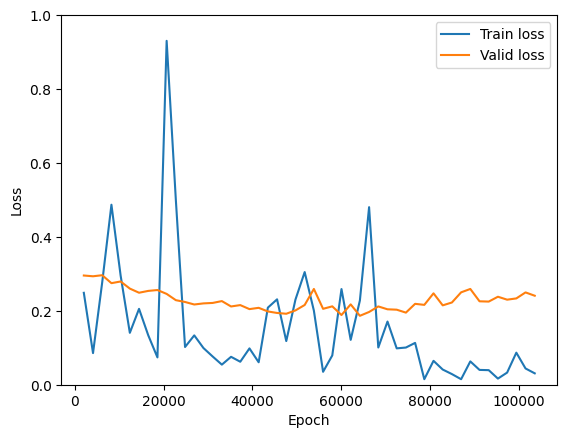

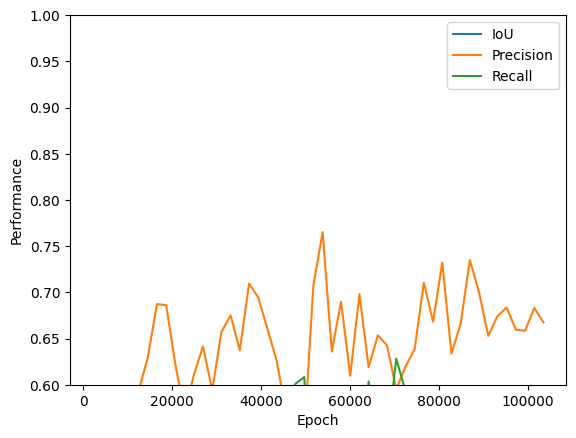

In [12]:
# Plot results
def plot_metrics(logger, type='lt'):
    '''Plot losses and IoU. `lt` is the logger used in Lightning.'''

    if type=='lt':
        metrics = logger.metrics
        epochs, _ = zip(*metrics['val_loss'])
        metrics = [list(zip(*metrics[k]))[1] for k in ['train_loss', 'val_loss', 'iou', 'prec', 'rec']]
        train_loss, valid_loss, iou, prec, rec = metrics    
    elif type=='pt':
        epochs, metrics = zip(*logger.data.items())
        train_loss, valid_loss, iou, prec, rec = zip(*metrics)

    plt.figure()
    plt.plot(epochs, train_loss, label='Train loss')
    plt.plot(epochs, valid_loss, label='Valid loss')
    plt.ylim((0, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.figure()
    plt.plot(epochs, iou, label='IoU')
    plt.plot(epochs, prec, label='Precision')
    plt.plot(epochs, rec, label='Recall')
    plt.ylim((0.6, 1))
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Performance')
    
plot_metrics(logger, type='lt')

## Visual Evaluation

In [19]:
def load_model_with_checkpoint(checkpoint_path, model):
    """
    Loads a PyTorch model with a checkpoint.

    Parameters
    ----------
        * checkpoint_path (str): The path to the checkpoint file.
        * model (nn.Module): The PyTorch model to load the checkpoint into.

    Returns
    -------
        * nn.Module: The PyTorch model with the loaded checkpoint.
    """
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cuda'))

    # Extract the state dictionary from the checkpoint
    state_dict = checkpoint['state_dict']

    # Create a new dictionary to store the model state
    new_state_dict = {}

    # Iterate over each item in the state dictionary
    for k, v in state_dict.items():
        # If the item's key starts with 'model.', remove this prefix from the key
        # and add the item to the new state dictionary
        if k.startswith('model.'):
            new_state_dict[k[6:]] = v

    # Load the model state from the new state dictionary
    model.load_state_dict(new_state_dict)

    # Put the model in evaluation mode
    model.eval()
    model.cuda()

    return model



In [28]:
checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers', 'hparams_name', 'hyper_parameters'])

In [31]:
model

LitSeg(
  (loss_func): CrossEntropyLoss()
  (model): FPN(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [35]:
checkpoint = torch.load('./logs/resunet_fpn_e_50_lr_0.01_bs_2/checkpoints/best_val_loss-epoch=30-val_loss=0.19.ckpt')
state_dict =checkpoint['state_dict']

model3 = resunet.ResUNet((3, 3, 3, 3), (16,32,64,128),  in_channels=3)
model3.load_state_dict(state_dict)



RuntimeError: Error(s) in loading state_dict for ResUNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "encoder.stage_0.0.conv1.weight", "encoder.stage_0.0.bn1.weight", "encoder.stage_0.0.bn1.bias", "encoder.stage_0.0.bn1.running_mean", "encoder.stage_0.0.bn1.running_var", "encoder.stage_0.0.conv2.weight", "encoder.stage_0.0.bn2.weight", "encoder.stage_0.0.bn2.bias", "encoder.stage_0.0.bn2.running_mean", "encoder.stage_0.0.bn2.running_var", "encoder.stage_0.0.downsample.0.weight", "encoder.stage_0.0.downsample.1.weight", "encoder.stage_0.0.downsample.1.bias", "encoder.stage_0.0.downsample.1.running_mean", "encoder.stage_0.0.downsample.1.running_var", "encoder.stage_0.1.conv1.weight", "encoder.stage_0.1.bn1.weight", "encoder.stage_0.1.bn1.bias", "encoder.stage_0.1.bn1.running_mean", "encoder.stage_0.1.bn1.running_var", "encoder.stage_0.1.conv2.weight", "encoder.stage_0.1.bn2.weight", "encoder.stage_0.1.bn2.bias", "encoder.stage_0.1.bn2.running_mean", "encoder.stage_0.1.bn2.running_var", "encoder.stage_0.2.conv1.weight", "encoder.stage_0.2.bn1.weight", "encoder.stage_0.2.bn1.bias", "encoder.stage_0.2.bn1.running_mean", "encoder.stage_0.2.bn1.running_var", "encoder.stage_0.2.conv2.weight", "encoder.stage_0.2.bn2.weight", "encoder.stage_0.2.bn2.bias", "encoder.stage_0.2.bn2.running_mean", "encoder.stage_0.2.bn2.running_var", "encoder.stage_1.0.conv1.weight", "encoder.stage_1.0.bn1.weight", "encoder.stage_1.0.bn1.bias", "encoder.stage_1.0.bn1.running_mean", "encoder.stage_1.0.bn1.running_var", "encoder.stage_1.0.conv2.weight", "encoder.stage_1.0.bn2.weight", "encoder.stage_1.0.bn2.bias", "encoder.stage_1.0.bn2.running_mean", "encoder.stage_1.0.bn2.running_var", "encoder.stage_1.0.downsample.0.weight", "encoder.stage_1.0.downsample.1.weight", "encoder.stage_1.0.downsample.1.bias", "encoder.stage_1.0.downsample.1.running_mean", "encoder.stage_1.0.downsample.1.running_var", "encoder.stage_1.1.conv1.weight", "encoder.stage_1.1.bn1.weight", "encoder.stage_1.1.bn1.bias", "encoder.stage_1.1.bn1.running_mean", "encoder.stage_1.1.bn1.running_var", "encoder.stage_1.1.conv2.weight", "encoder.stage_1.1.bn2.weight", "encoder.stage_1.1.bn2.bias", "encoder.stage_1.1.bn2.running_mean", "encoder.stage_1.1.bn2.running_var", "encoder.stage_1.2.conv1.weight", "encoder.stage_1.2.bn1.weight", "encoder.stage_1.2.bn1.bias", "encoder.stage_1.2.bn1.running_mean", "encoder.stage_1.2.bn1.running_var", "encoder.stage_1.2.conv2.weight", "encoder.stage_1.2.bn2.weight", "encoder.stage_1.2.bn2.bias", "encoder.stage_1.2.bn2.running_mean", "encoder.stage_1.2.bn2.running_var", "encoder.stage_2.0.conv1.weight", "encoder.stage_2.0.bn1.weight", "encoder.stage_2.0.bn1.bias", "encoder.stage_2.0.bn1.running_mean", "encoder.stage_2.0.bn1.running_var", "encoder.stage_2.0.conv2.weight", "encoder.stage_2.0.bn2.weight", "encoder.stage_2.0.bn2.bias", "encoder.stage_2.0.bn2.running_mean", "encoder.stage_2.0.bn2.running_var", "encoder.stage_2.0.downsample.0.weight", "encoder.stage_2.0.downsample.1.weight", "encoder.stage_2.0.downsample.1.bias", "encoder.stage_2.0.downsample.1.running_mean", "encoder.stage_2.0.downsample.1.running_var", "encoder.stage_2.1.conv1.weight", "encoder.stage_2.1.bn1.weight", "encoder.stage_2.1.bn1.bias", "encoder.stage_2.1.bn1.running_mean", "encoder.stage_2.1.bn1.running_var", "encoder.stage_2.1.conv2.weight", "encoder.stage_2.1.bn2.weight", "encoder.stage_2.1.bn2.bias", "encoder.stage_2.1.bn2.running_mean", "encoder.stage_2.1.bn2.running_var", "encoder.stage_2.2.conv1.weight", "encoder.stage_2.2.bn1.weight", "encoder.stage_2.2.bn1.bias", "encoder.stage_2.2.bn1.running_mean", "encoder.stage_2.2.bn1.running_var", "encoder.stage_2.2.conv2.weight", "encoder.stage_2.2.bn2.weight", "encoder.stage_2.2.bn2.bias", "encoder.stage_2.2.bn2.running_mean", "encoder.stage_2.2.bn2.running_var", "encoder.stage_3.0.conv1.weight", "encoder.stage_3.0.bn1.weight", "encoder.stage_3.0.bn1.bias", "encoder.stage_3.0.bn1.running_mean", "encoder.stage_3.0.bn1.running_var", "encoder.stage_3.0.conv2.weight", "encoder.stage_3.0.bn2.weight", "encoder.stage_3.0.bn2.bias", "encoder.stage_3.0.bn2.running_mean", "encoder.stage_3.0.bn2.running_var", "encoder.stage_3.0.downsample.0.weight", "encoder.stage_3.0.downsample.1.weight", "encoder.stage_3.0.downsample.1.bias", "encoder.stage_3.0.downsample.1.running_mean", "encoder.stage_3.0.downsample.1.running_var", "encoder.stage_3.1.conv1.weight", "encoder.stage_3.1.bn1.weight", "encoder.stage_3.1.bn1.bias", "encoder.stage_3.1.bn1.running_mean", "encoder.stage_3.1.bn1.running_var", "encoder.stage_3.1.conv2.weight", "encoder.stage_3.1.bn2.weight", "encoder.stage_3.1.bn2.bias", "encoder.stage_3.1.bn2.running_mean", "encoder.stage_3.1.bn2.running_var", "encoder.stage_3.2.conv1.weight", "encoder.stage_3.2.bn1.weight", "encoder.stage_3.2.bn1.bias", "encoder.stage_3.2.bn1.running_mean", "encoder.stage_3.2.bn1.running_var", "encoder.stage_3.2.conv2.weight", "encoder.stage_3.2.bn2.weight", "encoder.stage_3.2.bn2.bias", "encoder.stage_3.2.bn2.running_mean", "encoder.stage_3.2.bn2.running_var", "mid_block.conv1.weight", "mid_block.bn1.weight", "mid_block.bn1.bias", "mid_block.bn1.running_mean", "mid_block.bn1.running_var", "mid_block.conv2.weight", "mid_block.bn2.weight", "mid_block.bn2.bias", "mid_block.bn2.running_mean", "mid_block.bn2.running_var", "decoder.stage_3.0.conv.0.weight", "decoder.stage_3.0.conv.1.weight", "decoder.stage_3.0.conv.1.bias", "decoder.stage_3.0.conv.1.running_mean", "decoder.stage_3.0.conv.1.running_var", "decoder.stage_3.2.0.conv1.weight", "decoder.stage_3.2.0.bn1.weight", "decoder.stage_3.2.0.bn1.bias", "decoder.stage_3.2.0.bn1.running_mean", "decoder.stage_3.2.0.bn1.running_var", "decoder.stage_3.2.0.conv2.weight", "decoder.stage_3.2.0.bn2.weight", "decoder.stage_3.2.0.bn2.bias", "decoder.stage_3.2.0.bn2.running_mean", "decoder.stage_3.2.0.bn2.running_var", "decoder.stage_3.2.0.downsample.0.weight", "decoder.stage_3.2.0.downsample.1.weight", "decoder.stage_3.2.0.downsample.1.bias", "decoder.stage_3.2.0.downsample.1.running_mean", "decoder.stage_3.2.0.downsample.1.running_var", "decoder.stage_3.2.1.conv1.weight", "decoder.stage_3.2.1.bn1.weight", "decoder.stage_3.2.1.bn1.bias", "decoder.stage_3.2.1.bn1.running_mean", "decoder.stage_3.2.1.bn1.running_var", "decoder.stage_3.2.1.conv2.weight", "decoder.stage_3.2.1.bn2.weight", "decoder.stage_3.2.1.bn2.bias", "decoder.stage_3.2.1.bn2.running_mean", "decoder.stage_3.2.1.bn2.running_var", "decoder.stage_3.2.2.conv1.weight", "decoder.stage_3.2.2.bn1.weight", "decoder.stage_3.2.2.bn1.bias", "decoder.stage_3.2.2.bn1.running_mean", "decoder.stage_3.2.2.bn1.running_var", "decoder.stage_3.2.2.conv2.weight", "decoder.stage_3.2.2.bn2.weight", "decoder.stage_3.2.2.bn2.bias", "decoder.stage_3.2.2.bn2.running_mean", "decoder.stage_3.2.2.bn2.running_var", "decoder.stage_2.0.conv.0.weight", "decoder.stage_2.0.conv.1.weight", "decoder.stage_2.0.conv.1.bias", "decoder.stage_2.0.conv.1.running_mean", "decoder.stage_2.0.conv.1.running_var", "decoder.stage_2.2.0.conv1.weight", "decoder.stage_2.2.0.bn1.weight", "decoder.stage_2.2.0.bn1.bias", "decoder.stage_2.2.0.bn1.running_mean", "decoder.stage_2.2.0.bn1.running_var", "decoder.stage_2.2.0.conv2.weight", "decoder.stage_2.2.0.bn2.weight", "decoder.stage_2.2.0.bn2.bias", "decoder.stage_2.2.0.bn2.running_mean", "decoder.stage_2.2.0.bn2.running_var", "decoder.stage_2.2.0.downsample.0.weight", "decoder.stage_2.2.0.downsample.1.weight", "decoder.stage_2.2.0.downsample.1.bias", "decoder.stage_2.2.0.downsample.1.running_mean", "decoder.stage_2.2.0.downsample.1.running_var", "decoder.stage_2.2.1.conv1.weight", "decoder.stage_2.2.1.bn1.weight", "decoder.stage_2.2.1.bn1.bias", "decoder.stage_2.2.1.bn1.running_mean", "decoder.stage_2.2.1.bn1.running_var", "decoder.stage_2.2.1.conv2.weight", "decoder.stage_2.2.1.bn2.weight", "decoder.stage_2.2.1.bn2.bias", "decoder.stage_2.2.1.bn2.running_mean", "decoder.stage_2.2.1.bn2.running_var", "decoder.stage_2.2.2.conv1.weight", "decoder.stage_2.2.2.bn1.weight", "decoder.stage_2.2.2.bn1.bias", "decoder.stage_2.2.2.bn1.running_mean", "decoder.stage_2.2.2.bn1.running_var", "decoder.stage_2.2.2.conv2.weight", "decoder.stage_2.2.2.bn2.weight", "decoder.stage_2.2.2.bn2.bias", "decoder.stage_2.2.2.bn2.running_mean", "decoder.stage_2.2.2.bn2.running_var", "decoder.stage_1.0.conv.0.weight", "decoder.stage_1.0.conv.1.weight", "decoder.stage_1.0.conv.1.bias", "decoder.stage_1.0.conv.1.running_mean", "decoder.stage_1.0.conv.1.running_var", "decoder.stage_1.2.0.conv1.weight", "decoder.stage_1.2.0.bn1.weight", "decoder.stage_1.2.0.bn1.bias", "decoder.stage_1.2.0.bn1.running_mean", "decoder.stage_1.2.0.bn1.running_var", "decoder.stage_1.2.0.conv2.weight", "decoder.stage_1.2.0.bn2.weight", "decoder.stage_1.2.0.bn2.bias", "decoder.stage_1.2.0.bn2.running_mean", "decoder.stage_1.2.0.bn2.running_var", "decoder.stage_1.2.0.downsample.0.weight", "decoder.stage_1.2.0.downsample.1.weight", "decoder.stage_1.2.0.downsample.1.bias", "decoder.stage_1.2.0.downsample.1.running_mean", "decoder.stage_1.2.0.downsample.1.running_var", "decoder.stage_1.2.1.conv1.weight", "decoder.stage_1.2.1.bn1.weight", "decoder.stage_1.2.1.bn1.bias", "decoder.stage_1.2.1.bn1.running_mean", "decoder.stage_1.2.1.bn1.running_var", "decoder.stage_1.2.1.conv2.weight", "decoder.stage_1.2.1.bn2.weight", "decoder.stage_1.2.1.bn2.bias", "decoder.stage_1.2.1.bn2.running_mean", "decoder.stage_1.2.1.bn2.running_var", "decoder.stage_1.2.2.conv1.weight", "decoder.stage_1.2.2.bn1.weight", "decoder.stage_1.2.2.bn1.bias", "decoder.stage_1.2.2.bn1.running_mean", "decoder.stage_1.2.2.bn1.running_var", "decoder.stage_1.2.2.conv2.weight", "decoder.stage_1.2.2.bn2.weight", "decoder.stage_1.2.2.bn2.bias", "decoder.stage_1.2.2.bn2.running_mean", "decoder.stage_1.2.2.bn2.running_var", "decoder.stage_0.2.0.conv1.weight", "decoder.stage_0.2.0.bn1.weight", "decoder.stage_0.2.0.bn1.bias", "decoder.stage_0.2.0.bn1.running_mean", "decoder.stage_0.2.0.bn1.running_var", "decoder.stage_0.2.0.conv2.weight", "decoder.stage_0.2.0.bn2.weight", "decoder.stage_0.2.0.bn2.bias", "decoder.stage_0.2.0.bn2.running_mean", "decoder.stage_0.2.0.bn2.running_var", "decoder.stage_0.2.0.downsample.0.weight", "decoder.stage_0.2.0.downsample.1.weight", "decoder.stage_0.2.0.downsample.1.bias", "decoder.stage_0.2.0.downsample.1.running_mean", "decoder.stage_0.2.0.downsample.1.running_var", "decoder.stage_0.2.1.conv1.weight", "decoder.stage_0.2.1.bn1.weight", "decoder.stage_0.2.1.bn1.bias", "decoder.stage_0.2.1.bn1.running_mean", "decoder.stage_0.2.1.bn1.running_var", "decoder.stage_0.2.1.conv2.weight", "decoder.stage_0.2.1.bn2.weight", "decoder.stage_0.2.1.bn2.bias", "decoder.stage_0.2.1.bn2.running_mean", "decoder.stage_0.2.1.bn2.running_var", "decoder.stage_0.2.2.conv1.weight", "decoder.stage_0.2.2.bn1.weight", "decoder.stage_0.2.2.bn1.bias", "decoder.stage_0.2.2.bn1.running_mean", "decoder.stage_0.2.2.bn1.running_var", "decoder.stage_0.2.2.conv2.weight", "decoder.stage_0.2.2.bn2.weight", "decoder.stage_0.2.2.bn2.bias", "decoder.stage_0.2.2.bn2.running_mean", "decoder.stage_0.2.2.bn2.running_var", "conv_output.weight". 
	Unexpected key(s) in state_dict: "loss_func.weight", "model.encoder.conv1.weight", "model.encoder.bn1.weight", "model.encoder.bn1.bias", "model.encoder.bn1.running_mean", "model.encoder.bn1.running_var", "model.encoder.bn1.num_batches_tracked", "model.encoder.layer1.0.conv1.weight", "model.encoder.layer1.0.bn1.weight", "model.encoder.layer1.0.bn1.bias", "model.encoder.layer1.0.bn1.running_mean", "model.encoder.layer1.0.bn1.running_var", "model.encoder.layer1.0.bn1.num_batches_tracked", "model.encoder.layer1.0.conv2.weight", "model.encoder.layer1.0.bn2.weight", "model.encoder.layer1.0.bn2.bias", "model.encoder.layer1.0.bn2.running_mean", "model.encoder.layer1.0.bn2.running_var", "model.encoder.layer1.0.bn2.num_batches_tracked", "model.encoder.layer1.0.conv3.weight", "model.encoder.layer1.0.bn3.weight", "model.encoder.layer1.0.bn3.bias", "model.encoder.layer1.0.bn3.running_mean", "model.encoder.layer1.0.bn3.running_var", "model.encoder.layer1.0.bn3.num_batches_tracked", "model.encoder.layer1.0.downsample.0.weight", "model.encoder.layer1.0.downsample.1.weight", "model.encoder.layer1.0.downsample.1.bias", "model.encoder.layer1.0.downsample.1.running_mean", "model.encoder.layer1.0.downsample.1.running_var", "model.encoder.layer1.0.downsample.1.num_batches_tracked", "model.encoder.layer1.1.conv1.weight", "model.encoder.layer1.1.bn1.weight", "model.encoder.layer1.1.bn1.bias", "model.encoder.layer1.1.bn1.running_mean", "model.encoder.layer1.1.bn1.running_var", "model.encoder.layer1.1.bn1.num_batches_tracked", "model.encoder.layer1.1.conv2.weight", "model.encoder.layer1.1.bn2.weight", "model.encoder.layer1.1.bn2.bias", "model.encoder.layer1.1.bn2.running_mean", "model.encoder.layer1.1.bn2.running_var", "model.encoder.layer1.1.bn2.num_batches_tracked", "model.encoder.layer1.1.conv3.weight", "model.encoder.layer1.1.bn3.weight", "model.encoder.layer1.1.bn3.bias", "model.encoder.layer1.1.bn3.running_mean", "model.encoder.layer1.1.bn3.running_var", "model.encoder.layer1.1.bn3.num_batches_tracked", "model.encoder.layer1.2.conv1.weight", "model.encoder.layer1.2.bn1.weight", "model.encoder.layer1.2.bn1.bias", "model.encoder.layer1.2.bn1.running_mean", "model.encoder.layer1.2.bn1.running_var", "model.encoder.layer1.2.bn1.num_batches_tracked", "model.encoder.layer1.2.conv2.weight", "model.encoder.layer1.2.bn2.weight", "model.encoder.layer1.2.bn2.bias", "model.encoder.layer1.2.bn2.running_mean", "model.encoder.layer1.2.bn2.running_var", "model.encoder.layer1.2.bn2.num_batches_tracked", "model.encoder.layer1.2.conv3.weight", "model.encoder.layer1.2.bn3.weight", "model.encoder.layer1.2.bn3.bias", "model.encoder.layer1.2.bn3.running_mean", "model.encoder.layer1.2.bn3.running_var", "model.encoder.layer1.2.bn3.num_batches_tracked", "model.encoder.layer2.0.conv1.weight", "model.encoder.layer2.0.bn1.weight", "model.encoder.layer2.0.bn1.bias", "model.encoder.layer2.0.bn1.running_mean", "model.encoder.layer2.0.bn1.running_var", "model.encoder.layer2.0.bn1.num_batches_tracked", "model.encoder.layer2.0.conv2.weight", "model.encoder.layer2.0.bn2.weight", "model.encoder.layer2.0.bn2.bias", "model.encoder.layer2.0.bn2.running_mean", "model.encoder.layer2.0.bn2.running_var", "model.encoder.layer2.0.bn2.num_batches_tracked", "model.encoder.layer2.0.conv3.weight", "model.encoder.layer2.0.bn3.weight", "model.encoder.layer2.0.bn3.bias", "model.encoder.layer2.0.bn3.running_mean", "model.encoder.layer2.0.bn3.running_var", "model.encoder.layer2.0.bn3.num_batches_tracked", "model.encoder.layer2.0.downsample.0.weight", "model.encoder.layer2.0.downsample.1.weight", "model.encoder.layer2.0.downsample.1.bias", "model.encoder.layer2.0.downsample.1.running_mean", "model.encoder.layer2.0.downsample.1.running_var", "model.encoder.layer2.0.downsample.1.num_batches_tracked", "model.encoder.layer2.1.conv1.weight", "model.encoder.layer2.1.bn1.weight", "model.encoder.layer2.1.bn1.bias", "model.encoder.layer2.1.bn1.running_mean", "model.encoder.layer2.1.bn1.running_var", "model.encoder.layer2.1.bn1.num_batches_tracked", "model.encoder.layer2.1.conv2.weight", "model.encoder.layer2.1.bn2.weight", "model.encoder.layer2.1.bn2.bias", "model.encoder.layer2.1.bn2.running_mean", "model.encoder.layer2.1.bn2.running_var", "model.encoder.layer2.1.bn2.num_batches_tracked", "model.encoder.layer2.1.conv3.weight", "model.encoder.layer2.1.bn3.weight", "model.encoder.layer2.1.bn3.bias", "model.encoder.layer2.1.bn3.running_mean", "model.encoder.layer2.1.bn3.running_var", "model.encoder.layer2.1.bn3.num_batches_tracked", "model.encoder.layer2.2.conv1.weight", "model.encoder.layer2.2.bn1.weight", "model.encoder.layer2.2.bn1.bias", "model.encoder.layer2.2.bn1.running_mean", "model.encoder.layer2.2.bn1.running_var", "model.encoder.layer2.2.bn1.num_batches_tracked", "model.encoder.layer2.2.conv2.weight", "model.encoder.layer2.2.bn2.weight", "model.encoder.layer2.2.bn2.bias", "model.encoder.layer2.2.bn2.running_mean", "model.encoder.layer2.2.bn2.running_var", "model.encoder.layer2.2.bn2.num_batches_tracked", "model.encoder.layer2.2.conv3.weight", "model.encoder.layer2.2.bn3.weight", "model.encoder.layer2.2.bn3.bias", "model.encoder.layer2.2.bn3.running_mean", "model.encoder.layer2.2.bn3.running_var", "model.encoder.layer2.2.bn3.num_batches_tracked", "model.encoder.layer2.3.conv1.weight", "model.encoder.layer2.3.bn1.weight", "model.encoder.layer2.3.bn1.bias", "model.encoder.layer2.3.bn1.running_mean", "model.encoder.layer2.3.bn1.running_var", "model.encoder.layer2.3.bn1.num_batches_tracked", "model.encoder.layer2.3.conv2.weight", "model.encoder.layer2.3.bn2.weight", "model.encoder.layer2.3.bn2.bias", "model.encoder.layer2.3.bn2.running_mean", "model.encoder.layer2.3.bn2.running_var", "model.encoder.layer2.3.bn2.num_batches_tracked", "model.encoder.layer2.3.conv3.weight", "model.encoder.layer2.3.bn3.weight", "model.encoder.layer2.3.bn3.bias", "model.encoder.layer2.3.bn3.running_mean", "model.encoder.layer2.3.bn3.running_var", "model.encoder.layer2.3.bn3.num_batches_tracked", "model.encoder.layer3.0.conv1.weight", "model.encoder.layer3.0.bn1.weight", "model.encoder.layer3.0.bn1.bias", "model.encoder.layer3.0.bn1.running_mean", "model.encoder.layer3.0.bn1.running_var", "model.encoder.layer3.0.bn1.num_batches_tracked", "model.encoder.layer3.0.conv2.weight", "model.encoder.layer3.0.bn2.weight", "model.encoder.layer3.0.bn2.bias", "model.encoder.layer3.0.bn2.running_mean", "model.encoder.layer3.0.bn2.running_var", "model.encoder.layer3.0.bn2.num_batches_tracked", "model.encoder.layer3.0.conv3.weight", "model.encoder.layer3.0.bn3.weight", "model.encoder.layer3.0.bn3.bias", "model.encoder.layer3.0.bn3.running_mean", "model.encoder.layer3.0.bn3.running_var", "model.encoder.layer3.0.bn3.num_batches_tracked", "model.encoder.layer3.0.downsample.0.weight", "model.encoder.layer3.0.downsample.1.weight", "model.encoder.layer3.0.downsample.1.bias", "model.encoder.layer3.0.downsample.1.running_mean", "model.encoder.layer3.0.downsample.1.running_var", "model.encoder.layer3.0.downsample.1.num_batches_tracked", "model.encoder.layer3.1.conv1.weight", "model.encoder.layer3.1.bn1.weight", "model.encoder.layer3.1.bn1.bias", "model.encoder.layer3.1.bn1.running_mean", "model.encoder.layer3.1.bn1.running_var", "model.encoder.layer3.1.bn1.num_batches_tracked", "model.encoder.layer3.1.conv2.weight", "model.encoder.layer3.1.bn2.weight", "model.encoder.layer3.1.bn2.bias", "model.encoder.layer3.1.bn2.running_mean", "model.encoder.layer3.1.bn2.running_var", "model.encoder.layer3.1.bn2.num_batches_tracked", "model.encoder.layer3.1.conv3.weight", "model.encoder.layer3.1.bn3.weight", "model.encoder.layer3.1.bn3.bias", "model.encoder.layer3.1.bn3.running_mean", "model.encoder.layer3.1.bn3.running_var", "model.encoder.layer3.1.bn3.num_batches_tracked", "model.encoder.layer3.2.conv1.weight", "model.encoder.layer3.2.bn1.weight", "model.encoder.layer3.2.bn1.bias", "model.encoder.layer3.2.bn1.running_mean", "model.encoder.layer3.2.bn1.running_var", "model.encoder.layer3.2.bn1.num_batches_tracked", "model.encoder.layer3.2.conv2.weight", "model.encoder.layer3.2.bn2.weight", "model.encoder.layer3.2.bn2.bias", "model.encoder.layer3.2.bn2.running_mean", "model.encoder.layer3.2.bn2.running_var", "model.encoder.layer3.2.bn2.num_batches_tracked", "model.encoder.layer3.2.conv3.weight", "model.encoder.layer3.2.bn3.weight", "model.encoder.layer3.2.bn3.bias", "model.encoder.layer3.2.bn3.running_mean", "model.encoder.layer3.2.bn3.running_var", "model.encoder.layer3.2.bn3.num_batches_tracked", "model.encoder.layer3.3.conv1.weight", "model.encoder.layer3.3.bn1.weight", "model.encoder.layer3.3.bn1.bias", "model.encoder.layer3.3.bn1.running_mean", "model.encoder.layer3.3.bn1.running_var", "model.encoder.layer3.3.bn1.num_batches_tracked", "model.encoder.layer3.3.conv2.weight", "model.encoder.layer3.3.bn2.weight", "model.encoder.layer3.3.bn2.bias", "model.encoder.layer3.3.bn2.running_mean", "model.encoder.layer3.3.bn2.running_var", "model.encoder.layer3.3.bn2.num_batches_tracked", "model.encoder.layer3.3.conv3.weight", "model.encoder.layer3.3.bn3.weight", "model.encoder.layer3.3.bn3.bias", "model.encoder.layer3.3.bn3.running_mean", "model.encoder.layer3.3.bn3.running_var", "model.encoder.layer3.3.bn3.num_batches_tracked", "model.encoder.layer3.4.conv1.weight", "model.encoder.layer3.4.bn1.weight", "model.encoder.layer3.4.bn1.bias", "model.encoder.layer3.4.bn1.running_mean", "model.encoder.layer3.4.bn1.running_var", "model.encoder.layer3.4.bn1.num_batches_tracked", "model.encoder.layer3.4.conv2.weight", "model.encoder.layer3.4.bn2.weight", "model.encoder.layer3.4.bn2.bias", "model.encoder.layer3.4.bn2.running_mean", "model.encoder.layer3.4.bn2.running_var", "model.encoder.layer3.4.bn2.num_batches_tracked", "model.encoder.layer3.4.conv3.weight", "model.encoder.layer3.4.bn3.weight", "model.encoder.layer3.4.bn3.bias", "model.encoder.layer3.4.bn3.running_mean", "model.encoder.layer3.4.bn3.running_var", "model.encoder.layer3.4.bn3.num_batches_tracked", "model.encoder.layer3.5.conv1.weight", "model.encoder.layer3.5.bn1.weight", "model.encoder.layer3.5.bn1.bias", "model.encoder.layer3.5.bn1.running_mean", "model.encoder.layer3.5.bn1.running_var", "model.encoder.layer3.5.bn1.num_batches_tracked", "model.encoder.layer3.5.conv2.weight", "model.encoder.layer3.5.bn2.weight", "model.encoder.layer3.5.bn2.bias", "model.encoder.layer3.5.bn2.running_mean", "model.encoder.layer3.5.bn2.running_var", "model.encoder.layer3.5.bn2.num_batches_tracked", "model.encoder.layer3.5.conv3.weight", "model.encoder.layer3.5.bn3.weight", "model.encoder.layer3.5.bn3.bias", "model.encoder.layer3.5.bn3.running_mean", "model.encoder.layer3.5.bn3.running_var", "model.encoder.layer3.5.bn3.num_batches_tracked", "model.encoder.layer4.0.conv1.weight", "model.encoder.layer4.0.bn1.weight", "model.encoder.layer4.0.bn1.bias", "model.encoder.layer4.0.bn1.running_mean", "model.encoder.layer4.0.bn1.running_var", "model.encoder.layer4.0.bn1.num_batches_tracked", "model.encoder.layer4.0.conv2.weight", "model.encoder.layer4.0.bn2.weight", "model.encoder.layer4.0.bn2.bias", "model.encoder.layer4.0.bn2.running_mean", "model.encoder.layer4.0.bn2.running_var", "model.encoder.layer4.0.bn2.num_batches_tracked", "model.encoder.layer4.0.conv3.weight", "model.encoder.layer4.0.bn3.weight", "model.encoder.layer4.0.bn3.bias", "model.encoder.layer4.0.bn3.running_mean", "model.encoder.layer4.0.bn3.running_var", "model.encoder.layer4.0.bn3.num_batches_tracked", "model.encoder.layer4.0.downsample.0.weight", "model.encoder.layer4.0.downsample.1.weight", "model.encoder.layer4.0.downsample.1.bias", "model.encoder.layer4.0.downsample.1.running_mean", "model.encoder.layer4.0.downsample.1.running_var", "model.encoder.layer4.0.downsample.1.num_batches_tracked", "model.encoder.layer4.1.conv1.weight", "model.encoder.layer4.1.bn1.weight", "model.encoder.layer4.1.bn1.bias", "model.encoder.layer4.1.bn1.running_mean", "model.encoder.layer4.1.bn1.running_var", "model.encoder.layer4.1.bn1.num_batches_tracked", "model.encoder.layer4.1.conv2.weight", "model.encoder.layer4.1.bn2.weight", "model.encoder.layer4.1.bn2.bias", "model.encoder.layer4.1.bn2.running_mean", "model.encoder.layer4.1.bn2.running_var", "model.encoder.layer4.1.bn2.num_batches_tracked", "model.encoder.layer4.1.conv3.weight", "model.encoder.layer4.1.bn3.weight", "model.encoder.layer4.1.bn3.bias", "model.encoder.layer4.1.bn3.running_mean", "model.encoder.layer4.1.bn3.running_var", "model.encoder.layer4.1.bn3.num_batches_tracked", "model.encoder.layer4.2.conv1.weight", "model.encoder.layer4.2.bn1.weight", "model.encoder.layer4.2.bn1.bias", "model.encoder.layer4.2.bn1.running_mean", "model.encoder.layer4.2.bn1.running_var", "model.encoder.layer4.2.bn1.num_batches_tracked", "model.encoder.layer4.2.conv2.weight", "model.encoder.layer4.2.bn2.weight", "model.encoder.layer4.2.bn2.bias", "model.encoder.layer4.2.bn2.running_mean", "model.encoder.layer4.2.bn2.running_var", "model.encoder.layer4.2.bn2.num_batches_tracked", "model.encoder.layer4.2.conv3.weight", "model.encoder.layer4.2.bn3.weight", "model.encoder.layer4.2.bn3.bias", "model.encoder.layer4.2.bn3.running_mean", "model.encoder.layer4.2.bn3.running_var", "model.encoder.layer4.2.bn3.num_batches_tracked", "model.decoder.p5.weight", "model.decoder.p5.bias", "model.decoder.p4.skip_conv.weight", "model.decoder.p4.skip_conv.bias", "model.decoder.p3.skip_conv.weight", "model.decoder.p3.skip_conv.bias", "model.decoder.p2.skip_conv.weight", "model.decoder.p2.skip_conv.bias", "model.decoder.seg_blocks.0.block.0.block.0.weight", "model.decoder.seg_blocks.0.block.0.block.1.weight", "model.decoder.seg_blocks.0.block.0.block.1.bias", "model.decoder.seg_blocks.0.block.1.block.0.weight", "model.decoder.seg_blocks.0.block.1.block.1.weight", "model.decoder.seg_blocks.0.block.1.block.1.bias", "model.decoder.seg_blocks.0.block.2.block.0.weight", "model.decoder.seg_blocks.0.block.2.block.1.weight", "model.decoder.seg_blocks.0.block.2.block.1.bias", "model.decoder.seg_blocks.1.block.0.block.0.weight", "model.decoder.seg_blocks.1.block.0.block.1.weight", "model.decoder.seg_blocks.1.block.0.block.1.bias", "model.decoder.seg_blocks.1.block.1.block.0.weight", "model.decoder.seg_blocks.1.block.1.block.1.weight", "model.decoder.seg_blocks.1.block.1.block.1.bias", "model.decoder.seg_blocks.2.block.0.block.0.weight", "model.decoder.seg_blocks.2.block.0.block.1.weight", "model.decoder.seg_blocks.2.block.0.block.1.bias", "model.decoder.seg_blocks.3.block.0.block.0.weight", "model.decoder.seg_blocks.3.block.0.block.1.weight", "model.decoder.seg_blocks.3.block.0.block.1.bias", "model.segmentation_head.0.weight", "model.segmentation_head.0.bias". 

In [14]:
checkpoint_path1 = './logs/resunet_fpn_e_50_lr_0.01_bs_2/checkpoints/best_val_loss-epoch=30-val_loss=0.19.ckpt'
checkpoint_path2 = './logs/resunet_fpn_e_50_lr_0.01_bs_2/checkpoints/epoch=49-step=103500.ckpt'

model3 = resunet.ResUNet((3, 3, 3, 3), (16,32,64,128),  in_channels=3)
model3 = load_model_with_checkpoint(checkpoint_path1, model3)

model3 = resunet.ResUNet((3, 3, 3, 3), (16,32,64,128),  in_channels=3)
model3 = load_model_with_checkpoint(checkpoint_path2, model3)


RuntimeError: Error(s) in loading state_dict for ResUNet:
	Missing key(s) in state_dict: "conv1.weight", "bn1.weight", "bn1.bias", "bn1.running_mean", "bn1.running_var", "encoder.stage_0.0.conv1.weight", "encoder.stage_0.0.bn1.weight", "encoder.stage_0.0.bn1.bias", "encoder.stage_0.0.bn1.running_mean", "encoder.stage_0.0.bn1.running_var", "encoder.stage_0.0.conv2.weight", "encoder.stage_0.0.bn2.weight", "encoder.stage_0.0.bn2.bias", "encoder.stage_0.0.bn2.running_mean", "encoder.stage_0.0.bn2.running_var", "encoder.stage_0.0.downsample.0.weight", "encoder.stage_0.0.downsample.1.weight", "encoder.stage_0.0.downsample.1.bias", "encoder.stage_0.0.downsample.1.running_mean", "encoder.stage_0.0.downsample.1.running_var", "encoder.stage_0.1.conv1.weight", "encoder.stage_0.1.bn1.weight", "encoder.stage_0.1.bn1.bias", "encoder.stage_0.1.bn1.running_mean", "encoder.stage_0.1.bn1.running_var", "encoder.stage_0.1.conv2.weight", "encoder.stage_0.1.bn2.weight", "encoder.stage_0.1.bn2.bias", "encoder.stage_0.1.bn2.running_mean", "encoder.stage_0.1.bn2.running_var", "encoder.stage_0.2.conv1.weight", "encoder.stage_0.2.bn1.weight", "encoder.stage_0.2.bn1.bias", "encoder.stage_0.2.bn1.running_mean", "encoder.stage_0.2.bn1.running_var", "encoder.stage_0.2.conv2.weight", "encoder.stage_0.2.bn2.weight", "encoder.stage_0.2.bn2.bias", "encoder.stage_0.2.bn2.running_mean", "encoder.stage_0.2.bn2.running_var", "encoder.stage_1.0.conv1.weight", "encoder.stage_1.0.bn1.weight", "encoder.stage_1.0.bn1.bias", "encoder.stage_1.0.bn1.running_mean", "encoder.stage_1.0.bn1.running_var", "encoder.stage_1.0.conv2.weight", "encoder.stage_1.0.bn2.weight", "encoder.stage_1.0.bn2.bias", "encoder.stage_1.0.bn2.running_mean", "encoder.stage_1.0.bn2.running_var", "encoder.stage_1.0.downsample.0.weight", "encoder.stage_1.0.downsample.1.weight", "encoder.stage_1.0.downsample.1.bias", "encoder.stage_1.0.downsample.1.running_mean", "encoder.stage_1.0.downsample.1.running_var", "encoder.stage_1.1.conv1.weight", "encoder.stage_1.1.bn1.weight", "encoder.stage_1.1.bn1.bias", "encoder.stage_1.1.bn1.running_mean", "encoder.stage_1.1.bn1.running_var", "encoder.stage_1.1.conv2.weight", "encoder.stage_1.1.bn2.weight", "encoder.stage_1.1.bn2.bias", "encoder.stage_1.1.bn2.running_mean", "encoder.stage_1.1.bn2.running_var", "encoder.stage_1.2.conv1.weight", "encoder.stage_1.2.bn1.weight", "encoder.stage_1.2.bn1.bias", "encoder.stage_1.2.bn1.running_mean", "encoder.stage_1.2.bn1.running_var", "encoder.stage_1.2.conv2.weight", "encoder.stage_1.2.bn2.weight", "encoder.stage_1.2.bn2.bias", "encoder.stage_1.2.bn2.running_mean", "encoder.stage_1.2.bn2.running_var", "encoder.stage_2.0.conv1.weight", "encoder.stage_2.0.bn1.weight", "encoder.stage_2.0.bn1.bias", "encoder.stage_2.0.bn1.running_mean", "encoder.stage_2.0.bn1.running_var", "encoder.stage_2.0.conv2.weight", "encoder.stage_2.0.bn2.weight", "encoder.stage_2.0.bn2.bias", "encoder.stage_2.0.bn2.running_mean", "encoder.stage_2.0.bn2.running_var", "encoder.stage_2.0.downsample.0.weight", "encoder.stage_2.0.downsample.1.weight", "encoder.stage_2.0.downsample.1.bias", "encoder.stage_2.0.downsample.1.running_mean", "encoder.stage_2.0.downsample.1.running_var", "encoder.stage_2.1.conv1.weight", "encoder.stage_2.1.bn1.weight", "encoder.stage_2.1.bn1.bias", "encoder.stage_2.1.bn1.running_mean", "encoder.stage_2.1.bn1.running_var", "encoder.stage_2.1.conv2.weight", "encoder.stage_2.1.bn2.weight", "encoder.stage_2.1.bn2.bias", "encoder.stage_2.1.bn2.running_mean", "encoder.stage_2.1.bn2.running_var", "encoder.stage_2.2.conv1.weight", "encoder.stage_2.2.bn1.weight", "encoder.stage_2.2.bn1.bias", "encoder.stage_2.2.bn1.running_mean", "encoder.stage_2.2.bn1.running_var", "encoder.stage_2.2.conv2.weight", "encoder.stage_2.2.bn2.weight", "encoder.stage_2.2.bn2.bias", "encoder.stage_2.2.bn2.running_mean", "encoder.stage_2.2.bn2.running_var", "encoder.stage_3.0.conv1.weight", "encoder.stage_3.0.bn1.weight", "encoder.stage_3.0.bn1.bias", "encoder.stage_3.0.bn1.running_mean", "encoder.stage_3.0.bn1.running_var", "encoder.stage_3.0.conv2.weight", "encoder.stage_3.0.bn2.weight", "encoder.stage_3.0.bn2.bias", "encoder.stage_3.0.bn2.running_mean", "encoder.stage_3.0.bn2.running_var", "encoder.stage_3.0.downsample.0.weight", "encoder.stage_3.0.downsample.1.weight", "encoder.stage_3.0.downsample.1.bias", "encoder.stage_3.0.downsample.1.running_mean", "encoder.stage_3.0.downsample.1.running_var", "encoder.stage_3.1.conv1.weight", "encoder.stage_3.1.bn1.weight", "encoder.stage_3.1.bn1.bias", "encoder.stage_3.1.bn1.running_mean", "encoder.stage_3.1.bn1.running_var", "encoder.stage_3.1.conv2.weight", "encoder.stage_3.1.bn2.weight", "encoder.stage_3.1.bn2.bias", "encoder.stage_3.1.bn2.running_mean", "encoder.stage_3.1.bn2.running_var", "encoder.stage_3.2.conv1.weight", "encoder.stage_3.2.bn1.weight", "encoder.stage_3.2.bn1.bias", "encoder.stage_3.2.bn1.running_mean", "encoder.stage_3.2.bn1.running_var", "encoder.stage_3.2.conv2.weight", "encoder.stage_3.2.bn2.weight", "encoder.stage_3.2.bn2.bias", "encoder.stage_3.2.bn2.running_mean", "encoder.stage_3.2.bn2.running_var", "mid_block.conv1.weight", "mid_block.bn1.weight", "mid_block.bn1.bias", "mid_block.bn1.running_mean", "mid_block.bn1.running_var", "mid_block.conv2.weight", "mid_block.bn2.weight", "mid_block.bn2.bias", "mid_block.bn2.running_mean", "mid_block.bn2.running_var", "decoder.stage_3.0.conv.0.weight", "decoder.stage_3.0.conv.1.weight", "decoder.stage_3.0.conv.1.bias", "decoder.stage_3.0.conv.1.running_mean", "decoder.stage_3.0.conv.1.running_var", "decoder.stage_3.2.0.conv1.weight", "decoder.stage_3.2.0.bn1.weight", "decoder.stage_3.2.0.bn1.bias", "decoder.stage_3.2.0.bn1.running_mean", "decoder.stage_3.2.0.bn1.running_var", "decoder.stage_3.2.0.conv2.weight", "decoder.stage_3.2.0.bn2.weight", "decoder.stage_3.2.0.bn2.bias", "decoder.stage_3.2.0.bn2.running_mean", "decoder.stage_3.2.0.bn2.running_var", "decoder.stage_3.2.0.downsample.0.weight", "decoder.stage_3.2.0.downsample.1.weight", "decoder.stage_3.2.0.downsample.1.bias", "decoder.stage_3.2.0.downsample.1.running_mean", "decoder.stage_3.2.0.downsample.1.running_var", "decoder.stage_3.2.1.conv1.weight", "decoder.stage_3.2.1.bn1.weight", "decoder.stage_3.2.1.bn1.bias", "decoder.stage_3.2.1.bn1.running_mean", "decoder.stage_3.2.1.bn1.running_var", "decoder.stage_3.2.1.conv2.weight", "decoder.stage_3.2.1.bn2.weight", "decoder.stage_3.2.1.bn2.bias", "decoder.stage_3.2.1.bn2.running_mean", "decoder.stage_3.2.1.bn2.running_var", "decoder.stage_3.2.2.conv1.weight", "decoder.stage_3.2.2.bn1.weight", "decoder.stage_3.2.2.bn1.bias", "decoder.stage_3.2.2.bn1.running_mean", "decoder.stage_3.2.2.bn1.running_var", "decoder.stage_3.2.2.conv2.weight", "decoder.stage_3.2.2.bn2.weight", "decoder.stage_3.2.2.bn2.bias", "decoder.stage_3.2.2.bn2.running_mean", "decoder.stage_3.2.2.bn2.running_var", "decoder.stage_2.0.conv.0.weight", "decoder.stage_2.0.conv.1.weight", "decoder.stage_2.0.conv.1.bias", "decoder.stage_2.0.conv.1.running_mean", "decoder.stage_2.0.conv.1.running_var", "decoder.stage_2.2.0.conv1.weight", "decoder.stage_2.2.0.bn1.weight", "decoder.stage_2.2.0.bn1.bias", "decoder.stage_2.2.0.bn1.running_mean", "decoder.stage_2.2.0.bn1.running_var", "decoder.stage_2.2.0.conv2.weight", "decoder.stage_2.2.0.bn2.weight", "decoder.stage_2.2.0.bn2.bias", "decoder.stage_2.2.0.bn2.running_mean", "decoder.stage_2.2.0.bn2.running_var", "decoder.stage_2.2.0.downsample.0.weight", "decoder.stage_2.2.0.downsample.1.weight", "decoder.stage_2.2.0.downsample.1.bias", "decoder.stage_2.2.0.downsample.1.running_mean", "decoder.stage_2.2.0.downsample.1.running_var", "decoder.stage_2.2.1.conv1.weight", "decoder.stage_2.2.1.bn1.weight", "decoder.stage_2.2.1.bn1.bias", "decoder.stage_2.2.1.bn1.running_mean", "decoder.stage_2.2.1.bn1.running_var", "decoder.stage_2.2.1.conv2.weight", "decoder.stage_2.2.1.bn2.weight", "decoder.stage_2.2.1.bn2.bias", "decoder.stage_2.2.1.bn2.running_mean", "decoder.stage_2.2.1.bn2.running_var", "decoder.stage_2.2.2.conv1.weight", "decoder.stage_2.2.2.bn1.weight", "decoder.stage_2.2.2.bn1.bias", "decoder.stage_2.2.2.bn1.running_mean", "decoder.stage_2.2.2.bn1.running_var", "decoder.stage_2.2.2.conv2.weight", "decoder.stage_2.2.2.bn2.weight", "decoder.stage_2.2.2.bn2.bias", "decoder.stage_2.2.2.bn2.running_mean", "decoder.stage_2.2.2.bn2.running_var", "decoder.stage_1.0.conv.0.weight", "decoder.stage_1.0.conv.1.weight", "decoder.stage_1.0.conv.1.bias", "decoder.stage_1.0.conv.1.running_mean", "decoder.stage_1.0.conv.1.running_var", "decoder.stage_1.2.0.conv1.weight", "decoder.stage_1.2.0.bn1.weight", "decoder.stage_1.2.0.bn1.bias", "decoder.stage_1.2.0.bn1.running_mean", "decoder.stage_1.2.0.bn1.running_var", "decoder.stage_1.2.0.conv2.weight", "decoder.stage_1.2.0.bn2.weight", "decoder.stage_1.2.0.bn2.bias", "decoder.stage_1.2.0.bn2.running_mean", "decoder.stage_1.2.0.bn2.running_var", "decoder.stage_1.2.0.downsample.0.weight", "decoder.stage_1.2.0.downsample.1.weight", "decoder.stage_1.2.0.downsample.1.bias", "decoder.stage_1.2.0.downsample.1.running_mean", "decoder.stage_1.2.0.downsample.1.running_var", "decoder.stage_1.2.1.conv1.weight", "decoder.stage_1.2.1.bn1.weight", "decoder.stage_1.2.1.bn1.bias", "decoder.stage_1.2.1.bn1.running_mean", "decoder.stage_1.2.1.bn1.running_var", "decoder.stage_1.2.1.conv2.weight", "decoder.stage_1.2.1.bn2.weight", "decoder.stage_1.2.1.bn2.bias", "decoder.stage_1.2.1.bn2.running_mean", "decoder.stage_1.2.1.bn2.running_var", "decoder.stage_1.2.2.conv1.weight", "decoder.stage_1.2.2.bn1.weight", "decoder.stage_1.2.2.bn1.bias", "decoder.stage_1.2.2.bn1.running_mean", "decoder.stage_1.2.2.bn1.running_var", "decoder.stage_1.2.2.conv2.weight", "decoder.stage_1.2.2.bn2.weight", "decoder.stage_1.2.2.bn2.bias", "decoder.stage_1.2.2.bn2.running_mean", "decoder.stage_1.2.2.bn2.running_var", "decoder.stage_0.2.0.conv1.weight", "decoder.stage_0.2.0.bn1.weight", "decoder.stage_0.2.0.bn1.bias", "decoder.stage_0.2.0.bn1.running_mean", "decoder.stage_0.2.0.bn1.running_var", "decoder.stage_0.2.0.conv2.weight", "decoder.stage_0.2.0.bn2.weight", "decoder.stage_0.2.0.bn2.bias", "decoder.stage_0.2.0.bn2.running_mean", "decoder.stage_0.2.0.bn2.running_var", "decoder.stage_0.2.0.downsample.0.weight", "decoder.stage_0.2.0.downsample.1.weight", "decoder.stage_0.2.0.downsample.1.bias", "decoder.stage_0.2.0.downsample.1.running_mean", "decoder.stage_0.2.0.downsample.1.running_var", "decoder.stage_0.2.1.conv1.weight", "decoder.stage_0.2.1.bn1.weight", "decoder.stage_0.2.1.bn1.bias", "decoder.stage_0.2.1.bn1.running_mean", "decoder.stage_0.2.1.bn1.running_var", "decoder.stage_0.2.1.conv2.weight", "decoder.stage_0.2.1.bn2.weight", "decoder.stage_0.2.1.bn2.bias", "decoder.stage_0.2.1.bn2.running_mean", "decoder.stage_0.2.1.bn2.running_var", "decoder.stage_0.2.2.conv1.weight", "decoder.stage_0.2.2.bn1.weight", "decoder.stage_0.2.2.bn1.bias", "decoder.stage_0.2.2.bn1.running_mean", "decoder.stage_0.2.2.bn1.running_var", "decoder.stage_0.2.2.conv2.weight", "decoder.stage_0.2.2.bn2.weight", "decoder.stage_0.2.2.bn2.bias", "decoder.stage_0.2.2.bn2.running_mean", "decoder.stage_0.2.2.bn2.running_var", "conv_output.weight". 
	Unexpected key(s) in state_dict: "segmentation_head.0.weight", "segmentation_head.0.bias", "encoder.conv1.weight", "encoder.bn1.weight", "encoder.bn1.bias", "encoder.bn1.running_mean", "encoder.bn1.running_var", "encoder.bn1.num_batches_tracked", "encoder.layer1.0.conv1.weight", "encoder.layer1.0.bn1.weight", "encoder.layer1.0.bn1.bias", "encoder.layer1.0.bn1.running_mean", "encoder.layer1.0.bn1.running_var", "encoder.layer1.0.bn1.num_batches_tracked", "encoder.layer1.0.conv2.weight", "encoder.layer1.0.bn2.weight", "encoder.layer1.0.bn2.bias", "encoder.layer1.0.bn2.running_mean", "encoder.layer1.0.bn2.running_var", "encoder.layer1.0.bn2.num_batches_tracked", "encoder.layer1.0.conv3.weight", "encoder.layer1.0.bn3.weight", "encoder.layer1.0.bn3.bias", "encoder.layer1.0.bn3.running_mean", "encoder.layer1.0.bn3.running_var", "encoder.layer1.0.bn3.num_batches_tracked", "encoder.layer1.0.downsample.0.weight", "encoder.layer1.0.downsample.1.weight", "encoder.layer1.0.downsample.1.bias", "encoder.layer1.0.downsample.1.running_mean", "encoder.layer1.0.downsample.1.running_var", "encoder.layer1.0.downsample.1.num_batches_tracked", "encoder.layer1.1.conv1.weight", "encoder.layer1.1.bn1.weight", "encoder.layer1.1.bn1.bias", "encoder.layer1.1.bn1.running_mean", "encoder.layer1.1.bn1.running_var", "encoder.layer1.1.bn1.num_batches_tracked", "encoder.layer1.1.conv2.weight", "encoder.layer1.1.bn2.weight", "encoder.layer1.1.bn2.bias", "encoder.layer1.1.bn2.running_mean", "encoder.layer1.1.bn2.running_var", "encoder.layer1.1.bn2.num_batches_tracked", "encoder.layer1.1.conv3.weight", "encoder.layer1.1.bn3.weight", "encoder.layer1.1.bn3.bias", "encoder.layer1.1.bn3.running_mean", "encoder.layer1.1.bn3.running_var", "encoder.layer1.1.bn3.num_batches_tracked", "encoder.layer1.2.conv1.weight", "encoder.layer1.2.bn1.weight", "encoder.layer1.2.bn1.bias", "encoder.layer1.2.bn1.running_mean", "encoder.layer1.2.bn1.running_var", "encoder.layer1.2.bn1.num_batches_tracked", "encoder.layer1.2.conv2.weight", "encoder.layer1.2.bn2.weight", "encoder.layer1.2.bn2.bias", "encoder.layer1.2.bn2.running_mean", "encoder.layer1.2.bn2.running_var", "encoder.layer1.2.bn2.num_batches_tracked", "encoder.layer1.2.conv3.weight", "encoder.layer1.2.bn3.weight", "encoder.layer1.2.bn3.bias", "encoder.layer1.2.bn3.running_mean", "encoder.layer1.2.bn3.running_var", "encoder.layer1.2.bn3.num_batches_tracked", "encoder.layer2.0.conv1.weight", "encoder.layer2.0.bn1.weight", "encoder.layer2.0.bn1.bias", "encoder.layer2.0.bn1.running_mean", "encoder.layer2.0.bn1.running_var", "encoder.layer2.0.bn1.num_batches_tracked", "encoder.layer2.0.conv2.weight", "encoder.layer2.0.bn2.weight", "encoder.layer2.0.bn2.bias", "encoder.layer2.0.bn2.running_mean", "encoder.layer2.0.bn2.running_var", "encoder.layer2.0.bn2.num_batches_tracked", "encoder.layer2.0.conv3.weight", "encoder.layer2.0.bn3.weight", "encoder.layer2.0.bn3.bias", "encoder.layer2.0.bn3.running_mean", "encoder.layer2.0.bn3.running_var", "encoder.layer2.0.bn3.num_batches_tracked", "encoder.layer2.0.downsample.0.weight", "encoder.layer2.0.downsample.1.weight", "encoder.layer2.0.downsample.1.bias", "encoder.layer2.0.downsample.1.running_mean", "encoder.layer2.0.downsample.1.running_var", "encoder.layer2.0.downsample.1.num_batches_tracked", "encoder.layer2.1.conv1.weight", "encoder.layer2.1.bn1.weight", "encoder.layer2.1.bn1.bias", "encoder.layer2.1.bn1.running_mean", "encoder.layer2.1.bn1.running_var", "encoder.layer2.1.bn1.num_batches_tracked", "encoder.layer2.1.conv2.weight", "encoder.layer2.1.bn2.weight", "encoder.layer2.1.bn2.bias", "encoder.layer2.1.bn2.running_mean", "encoder.layer2.1.bn2.running_var", "encoder.layer2.1.bn2.num_batches_tracked", "encoder.layer2.1.conv3.weight", "encoder.layer2.1.bn3.weight", "encoder.layer2.1.bn3.bias", "encoder.layer2.1.bn3.running_mean", "encoder.layer2.1.bn3.running_var", "encoder.layer2.1.bn3.num_batches_tracked", "encoder.layer2.2.conv1.weight", "encoder.layer2.2.bn1.weight", "encoder.layer2.2.bn1.bias", "encoder.layer2.2.bn1.running_mean", "encoder.layer2.2.bn1.running_var", "encoder.layer2.2.bn1.num_batches_tracked", "encoder.layer2.2.conv2.weight", "encoder.layer2.2.bn2.weight", "encoder.layer2.2.bn2.bias", "encoder.layer2.2.bn2.running_mean", "encoder.layer2.2.bn2.running_var", "encoder.layer2.2.bn2.num_batches_tracked", "encoder.layer2.2.conv3.weight", "encoder.layer2.2.bn3.weight", "encoder.layer2.2.bn3.bias", "encoder.layer2.2.bn3.running_mean", "encoder.layer2.2.bn3.running_var", "encoder.layer2.2.bn3.num_batches_tracked", "encoder.layer2.3.conv1.weight", "encoder.layer2.3.bn1.weight", "encoder.layer2.3.bn1.bias", "encoder.layer2.3.bn1.running_mean", "encoder.layer2.3.bn1.running_var", "encoder.layer2.3.bn1.num_batches_tracked", "encoder.layer2.3.conv2.weight", "encoder.layer2.3.bn2.weight", "encoder.layer2.3.bn2.bias", "encoder.layer2.3.bn2.running_mean", "encoder.layer2.3.bn2.running_var", "encoder.layer2.3.bn2.num_batches_tracked", "encoder.layer2.3.conv3.weight", "encoder.layer2.3.bn3.weight", "encoder.layer2.3.bn3.bias", "encoder.layer2.3.bn3.running_mean", "encoder.layer2.3.bn3.running_var", "encoder.layer2.3.bn3.num_batches_tracked", "encoder.layer3.0.conv1.weight", "encoder.layer3.0.bn1.weight", "encoder.layer3.0.bn1.bias", "encoder.layer3.0.bn1.running_mean", "encoder.layer3.0.bn1.running_var", "encoder.layer3.0.bn1.num_batches_tracked", "encoder.layer3.0.conv2.weight", "encoder.layer3.0.bn2.weight", "encoder.layer3.0.bn2.bias", "encoder.layer3.0.bn2.running_mean", "encoder.layer3.0.bn2.running_var", "encoder.layer3.0.bn2.num_batches_tracked", "encoder.layer3.0.conv3.weight", "encoder.layer3.0.bn3.weight", "encoder.layer3.0.bn3.bias", "encoder.layer3.0.bn3.running_mean", "encoder.layer3.0.bn3.running_var", "encoder.layer3.0.bn3.num_batches_tracked", "encoder.layer3.0.downsample.0.weight", "encoder.layer3.0.downsample.1.weight", "encoder.layer3.0.downsample.1.bias", "encoder.layer3.0.downsample.1.running_mean", "encoder.layer3.0.downsample.1.running_var", "encoder.layer3.0.downsample.1.num_batches_tracked", "encoder.layer3.1.conv1.weight", "encoder.layer3.1.bn1.weight", "encoder.layer3.1.bn1.bias", "encoder.layer3.1.bn1.running_mean", "encoder.layer3.1.bn1.running_var", "encoder.layer3.1.bn1.num_batches_tracked", "encoder.layer3.1.conv2.weight", "encoder.layer3.1.bn2.weight", "encoder.layer3.1.bn2.bias", "encoder.layer3.1.bn2.running_mean", "encoder.layer3.1.bn2.running_var", "encoder.layer3.1.bn2.num_batches_tracked", "encoder.layer3.1.conv3.weight", "encoder.layer3.1.bn3.weight", "encoder.layer3.1.bn3.bias", "encoder.layer3.1.bn3.running_mean", "encoder.layer3.1.bn3.running_var", "encoder.layer3.1.bn3.num_batches_tracked", "encoder.layer3.2.conv1.weight", "encoder.layer3.2.bn1.weight", "encoder.layer3.2.bn1.bias", "encoder.layer3.2.bn1.running_mean", "encoder.layer3.2.bn1.running_var", "encoder.layer3.2.bn1.num_batches_tracked", "encoder.layer3.2.conv2.weight", "encoder.layer3.2.bn2.weight", "encoder.layer3.2.bn2.bias", "encoder.layer3.2.bn2.running_mean", "encoder.layer3.2.bn2.running_var", "encoder.layer3.2.bn2.num_batches_tracked", "encoder.layer3.2.conv3.weight", "encoder.layer3.2.bn3.weight", "encoder.layer3.2.bn3.bias", "encoder.layer3.2.bn3.running_mean", "encoder.layer3.2.bn3.running_var", "encoder.layer3.2.bn3.num_batches_tracked", "encoder.layer3.3.conv1.weight", "encoder.layer3.3.bn1.weight", "encoder.layer3.3.bn1.bias", "encoder.layer3.3.bn1.running_mean", "encoder.layer3.3.bn1.running_var", "encoder.layer3.3.bn1.num_batches_tracked", "encoder.layer3.3.conv2.weight", "encoder.layer3.3.bn2.weight", "encoder.layer3.3.bn2.bias", "encoder.layer3.3.bn2.running_mean", "encoder.layer3.3.bn2.running_var", "encoder.layer3.3.bn2.num_batches_tracked", "encoder.layer3.3.conv3.weight", "encoder.layer3.3.bn3.weight", "encoder.layer3.3.bn3.bias", "encoder.layer3.3.bn3.running_mean", "encoder.layer3.3.bn3.running_var", "encoder.layer3.3.bn3.num_batches_tracked", "encoder.layer3.4.conv1.weight", "encoder.layer3.4.bn1.weight", "encoder.layer3.4.bn1.bias", "encoder.layer3.4.bn1.running_mean", "encoder.layer3.4.bn1.running_var", "encoder.layer3.4.bn1.num_batches_tracked", "encoder.layer3.4.conv2.weight", "encoder.layer3.4.bn2.weight", "encoder.layer3.4.bn2.bias", "encoder.layer3.4.bn2.running_mean", "encoder.layer3.4.bn2.running_var", "encoder.layer3.4.bn2.num_batches_tracked", "encoder.layer3.4.conv3.weight", "encoder.layer3.4.bn3.weight", "encoder.layer3.4.bn3.bias", "encoder.layer3.4.bn3.running_mean", "encoder.layer3.4.bn3.running_var", "encoder.layer3.4.bn3.num_batches_tracked", "encoder.layer3.5.conv1.weight", "encoder.layer3.5.bn1.weight", "encoder.layer3.5.bn1.bias", "encoder.layer3.5.bn1.running_mean", "encoder.layer3.5.bn1.running_var", "encoder.layer3.5.bn1.num_batches_tracked", "encoder.layer3.5.conv2.weight", "encoder.layer3.5.bn2.weight", "encoder.layer3.5.bn2.bias", "encoder.layer3.5.bn2.running_mean", "encoder.layer3.5.bn2.running_var", "encoder.layer3.5.bn2.num_batches_tracked", "encoder.layer3.5.conv3.weight", "encoder.layer3.5.bn3.weight", "encoder.layer3.5.bn3.bias", "encoder.layer3.5.bn3.running_mean", "encoder.layer3.5.bn3.running_var", "encoder.layer3.5.bn3.num_batches_tracked", "encoder.layer4.0.conv1.weight", "encoder.layer4.0.bn1.weight", "encoder.layer4.0.bn1.bias", "encoder.layer4.0.bn1.running_mean", "encoder.layer4.0.bn1.running_var", "encoder.layer4.0.bn1.num_batches_tracked", "encoder.layer4.0.conv2.weight", "encoder.layer4.0.bn2.weight", "encoder.layer4.0.bn2.bias", "encoder.layer4.0.bn2.running_mean", "encoder.layer4.0.bn2.running_var", "encoder.layer4.0.bn2.num_batches_tracked", "encoder.layer4.0.conv3.weight", "encoder.layer4.0.bn3.weight", "encoder.layer4.0.bn3.bias", "encoder.layer4.0.bn3.running_mean", "encoder.layer4.0.bn3.running_var", "encoder.layer4.0.bn3.num_batches_tracked", "encoder.layer4.0.downsample.0.weight", "encoder.layer4.0.downsample.1.weight", "encoder.layer4.0.downsample.1.bias", "encoder.layer4.0.downsample.1.running_mean", "encoder.layer4.0.downsample.1.running_var", "encoder.layer4.0.downsample.1.num_batches_tracked", "encoder.layer4.1.conv1.weight", "encoder.layer4.1.bn1.weight", "encoder.layer4.1.bn1.bias", "encoder.layer4.1.bn1.running_mean", "encoder.layer4.1.bn1.running_var", "encoder.layer4.1.bn1.num_batches_tracked", "encoder.layer4.1.conv2.weight", "encoder.layer4.1.bn2.weight", "encoder.layer4.1.bn2.bias", "encoder.layer4.1.bn2.running_mean", "encoder.layer4.1.bn2.running_var", "encoder.layer4.1.bn2.num_batches_tracked", "encoder.layer4.1.conv3.weight", "encoder.layer4.1.bn3.weight", "encoder.layer4.1.bn3.bias", "encoder.layer4.1.bn3.running_mean", "encoder.layer4.1.bn3.running_var", "encoder.layer4.1.bn3.num_batches_tracked", "encoder.layer4.2.conv1.weight", "encoder.layer4.2.bn1.weight", "encoder.layer4.2.bn1.bias", "encoder.layer4.2.bn1.running_mean", "encoder.layer4.2.bn1.running_var", "encoder.layer4.2.bn1.num_batches_tracked", "encoder.layer4.2.conv2.weight", "encoder.layer4.2.bn2.weight", "encoder.layer4.2.bn2.bias", "encoder.layer4.2.bn2.running_mean", "encoder.layer4.2.bn2.running_var", "encoder.layer4.2.bn2.num_batches_tracked", "encoder.layer4.2.conv3.weight", "encoder.layer4.2.bn3.weight", "encoder.layer4.2.bn3.bias", "encoder.layer4.2.bn3.running_mean", "encoder.layer4.2.bn3.running_var", "encoder.layer4.2.bn3.num_batches_tracked", "decoder.p5.weight", "decoder.p5.bias", "decoder.p4.skip_conv.weight", "decoder.p4.skip_conv.bias", "decoder.p3.skip_conv.weight", "decoder.p3.skip_conv.bias", "decoder.p2.skip_conv.weight", "decoder.p2.skip_conv.bias", "decoder.seg_blocks.0.block.0.block.0.weight", "decoder.seg_blocks.0.block.0.block.1.weight", "decoder.seg_blocks.0.block.0.block.1.bias", "decoder.seg_blocks.0.block.1.block.0.weight", "decoder.seg_blocks.0.block.1.block.1.weight", "decoder.seg_blocks.0.block.1.block.1.bias", "decoder.seg_blocks.0.block.2.block.0.weight", "decoder.seg_blocks.0.block.2.block.1.weight", "decoder.seg_blocks.0.block.2.block.1.bias", "decoder.seg_blocks.1.block.0.block.0.weight", "decoder.seg_blocks.1.block.0.block.1.weight", "decoder.seg_blocks.1.block.0.block.1.bias", "decoder.seg_blocks.1.block.1.block.0.weight", "decoder.seg_blocks.1.block.1.block.1.weight", "decoder.seg_blocks.1.block.1.block.1.bias", "decoder.seg_blocks.2.block.0.block.0.weight", "decoder.seg_blocks.2.block.0.block.1.weight", "decoder.seg_blocks.2.block.0.block.1.bias", "decoder.seg_blocks.3.block.0.block.0.weight", "decoder.seg_blocks.3.block.0.block.1.weight", "decoder.seg_blocks.3.block.0.block.1.bias". 

In [22]:
def plot_examples(ds, model1, model2, model3, n=4):
    """Plot some example segmentations"""

    indices = random.sample(range(len(ds)),n)
    
    for i, idx in enumerate(indices):
        x, y = ds[idx]
        x_or, y_or = ds.get_item(idx)
        with torch.no_grad():
            y_pred1 = model1(x[None].cuda())[0].cpu()
            y_pred2 = model2(x[None].cuda())[0].cpu()
            y_pred3 = model3(x[None].cuda())[0].cpu() 
                       
        
        x = x*0.2347+0.4394
        
        y_pred1 = torch.max(y_pred1, dim=0)[1]
        y_pred2 = torch.max(y_pred2, dim=0)[1]
        y_pred3 = torch.max(y_pred3, dim=0)[1]
        
        iou1 = perf_funcs.segmentation_accuracy(y_pred1, y[None], meas = ['iou'])
        iou2 = perf_funcs.segmentation_accuracy(y_pred2, y[None], meas = ['iou'])
        iou3 = perf_funcs.segmentation_accuracy(y_pred3, y[None], meas = ['iou'])
    
        plt.figure(figsize=[20,5])
        plt.subplot(1, 6, 1)
        plt.imshow(x_or.permute(1, 2, 0), 'gray')
        plt.title('Original image')
        plt.subplot(1, 6, 2)
        plt.imshow(x.permute(1, 2, 0), 'gray')
        plt.title('Augmented image')
        plt.subplot(1, 6, 3)
        plt.imshow(y==1, 'gray')
        plt.title('Ground truth')
        plt.subplot(1, 6, 4)
        plt.imshow(y_pred1, 'gray')
        plt.title(f'Pred Model 1 \niou: {iou1.numpy():.2f}')
        plt.subplot(1, 6, 5)
        plt.imshow(y_pred2, 'gray')
        plt.title(f'Pred Model 2 \niou: {iou2.numpy():.2f}')
        plt.subplot(1, 6, 6)
        plt.imshow(y_pred3, 'gray')
        plt.title(f'Pred Model 3 \niou: {iou3.numpy():.2f}')
        plt.show()



In [24]:
plot_examples(ds_valid, model, model, model, n=3)

RuntimeError: Wrong input shape height=569, width=1536. Expected image height and width divisible by 32. Consider pad your images to shape (576, 1536).